🚀 Using device: cuda
📂 Loading dataset from: melspectrograms_dataset
⚖️ Loading model from: checkpoints_fusion_v3/best_full_fusion_v3.pth


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Found 74 images in 'test' set, across 6 classes.

Instantiating model architecture...
Loading weights from checkpoints_fusion_v3/best_full_fusion_v3.pth...


📊 Evaluating on Test Set:   0%|          | 0/5 [00:00<?, ?it/s]


                EVALUATION RESULTS

✅ Test Accuracy: 0.8514 (85.14%)

📊 Classification Report:
                        precision    recall  f1-score   support

             Dysarthia     1.0000    1.0000    1.0000        13
            Laryngitis     0.6154    0.6154    0.6154        13
           Laryngozele     0.8000    0.8889    0.8421         9
           Vox senilis     0.8462    0.8462    0.8462        13
             parkinson     1.0000    1.0000    1.0000        13
spasmodische_dysphonie     0.8333    0.7692    0.8000        13

              accuracy                         0.8514        74
             macro avg     0.8491    0.8533    0.8506        74
          weighted avg     0.8518    0.8514    0.8511        74


🖼️  Classification report saved to: classification_report.png
🖼️  Confusion matrix saved to: confusion_matrix.png

✨ Evaluation complete.


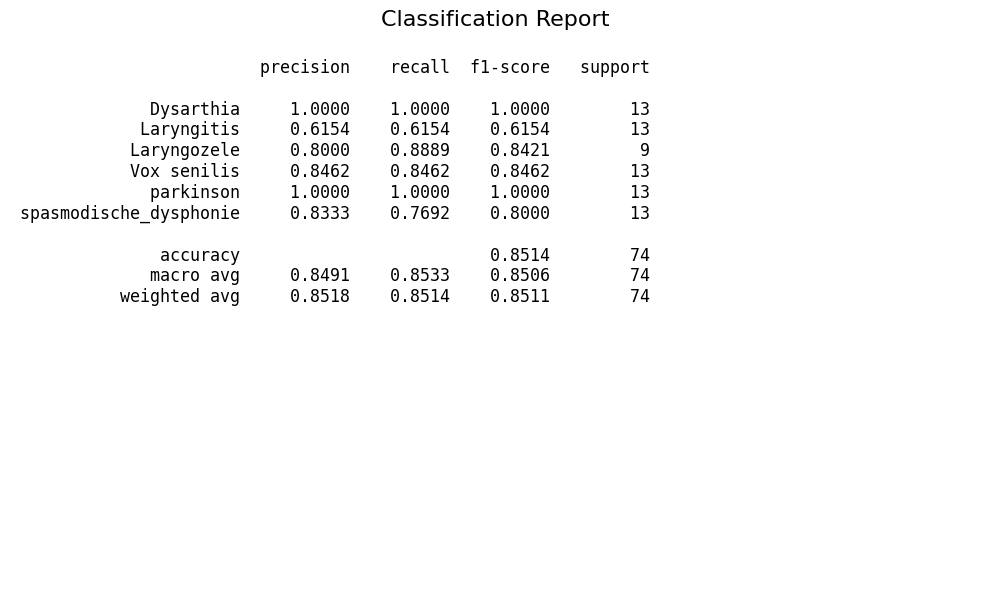

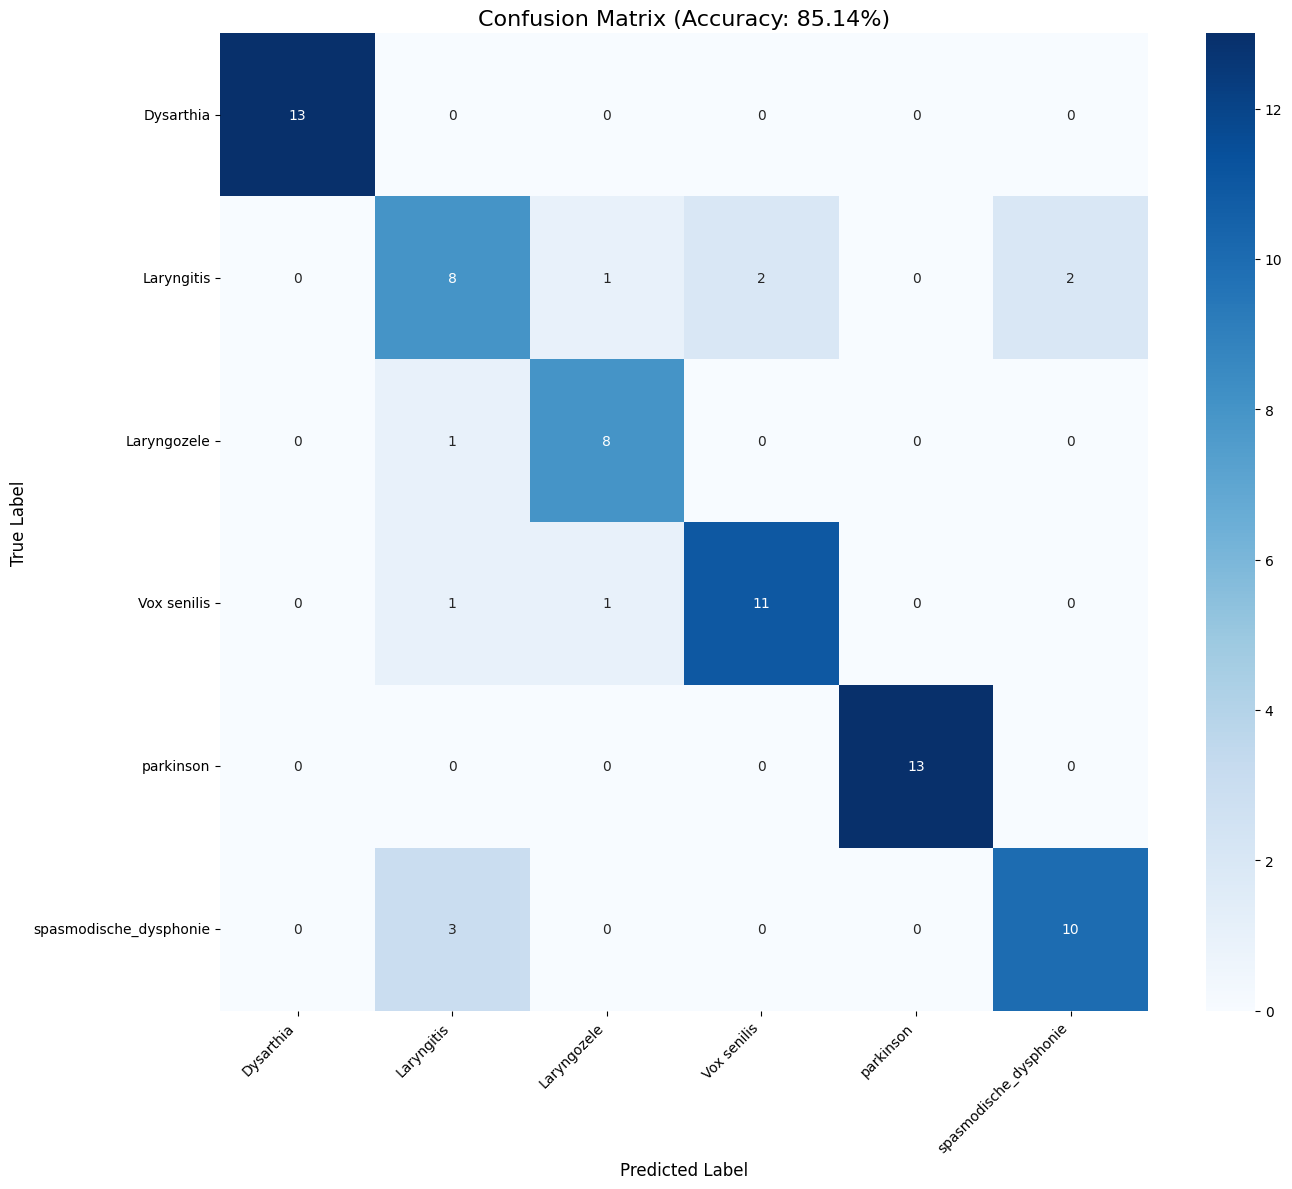

In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm.auto import tqdm
import warnings

# --- Third-party imports ---
import timm
from transformers import AutoModel, AutoImageProcessor
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- Suppress warnings for cleaner output ---
warnings.filterwarnings("ignore")

# %%
# =============================================================================
# 1. CONFIGURATION
# =============================================================================
class TestConfig:
    """Configuration for the testing script. Modify paths here."""
    # --- IMPORTANT: Set these paths correctly ---
    # Path to the root folder of your dataset
    DATASET_DIR = "melspectrograms_dataset"
    # Path to the final trained model checkpoint you want to evaluate
    MODEL_CHECKPOINT_PATH = "checkpoints_fusion_v3/best_full_fusion_v3.pth"

    # --- Model and Image parameters (should match training) ---
    IMG_SIZE = 224
    COATNET_MODEL = "coatnet_0_rw_224"
    DINO_MODEL = "facebook/dinov2-small"

    # --- Dataloader parameters ---
    BATCH_SIZE = 16  # Adjust based on your GPU memory
    NUM_WORKERS = 0  # Use 0 for compatibility, or 2-4 if you know it works on your system

    # --- Output file names ---
    CONFUSION_MATRIX_FILE = "confusion_matrix.png"
    CLASSIFICATION_REPORT_FILE = "classification_report.png"

    # --- Device Configuration ---
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = TestConfig()
print(f"🚀 Using device: {config.DEVICE}")
print(f"📂 Loading dataset from: {config.DATASET_DIR}")
print(f"⚖️ Loading model from: {config.MODEL_CHECKPOINT_PATH}")


# %%
# =============================================================================
# 2. MODEL DEFINITIONS
# (These must EXACTLY match the architecture of the saved model)
# =============================================================================

class GALA_Attention(nn.Module):
    def __init__(self, dim, n_heads=6, qkv_bias=True, attn_drop=0., proj_drop=0.):
        super().__init__()
        assert dim % n_heads == 0; self.n_heads = n_heads; self.head_dim = dim // n_heads
        self.scale = self.head_dim ** -0.5; self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop); self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        self.focal_gamma = nn.Parameter(torch.ones(n_heads, 1, 1))
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.n_heads, self.head_dim).permute(2,0,3,1,4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn_w = torch.softmax(attn, dim=-1)
        focal = torch.pow(1.0 - attn_w, self.focal_gamma)
        attn_mod = attn_w * focal
        attn_mod = attn_mod / (attn_mod.sum(dim=-1, keepdim=True) + 1e-6)
        out = (self.attn_drop(attn_mod) @ v).transpose(1,2).reshape(B,N,C)
        return self.proj_drop(self.proj(out))

class GFT_Encoder_Minimal(nn.Module):
    def __init__(self, embed_dim, num_stages=3, n_heads=6, drop_rate=0.3):
        super().__init__()
        self.stages = nn.ModuleList([
            nn.Sequential(nn.LayerNorm(embed_dim), GALA_Attention(embed_dim, n_heads=n_heads),
                          nn.LayerNorm(embed_dim), nn.Linear(embed_dim, embed_dim), nn.GELU(), nn.Dropout(drop_rate)
            ) for _ in range(num_stages)])
    def forward(self, x):
        for s in self.stages: x = s(x)
        return x

class DinoV2_GFT_Minimal(nn.Module):
    def __init__(self, model_name=config.DINO_MODEL, num_classes=10, gft_stages=3, n_heads=6, drop_rate=0.3):
        super().__init__()
        self.backbone = AutoModel.from_pretrained(model_name)
        embed_dim = self.backbone.config.hidden_size
        self.embed_dim = embed_dim
        self.gft_encoder = GFT_Encoder_Minimal(embed_dim, num_stages=gft_stages)
        self.pool_norm = nn.LayerNorm(embed_dim)
        self.classifier = nn.Sequential(nn.Linear(embed_dim, 512), nn.GELU(), nn.Dropout(drop_rate), nn.Linear(512, 256), nn.GELU(), nn.Dropout(drop_rate*0.5), nn.Linear(256, num_classes))
    def forward(self, pixel_values, token_mask=None):
        tokens = self.backbone(pixel_values=pixel_values).last_hidden_state
        if token_mask is not None: tokens = tokens * token_mask.unsqueeze(-1)
        features = self.gft_encoder(tokens)
        pooled = self.pool_norm(torch.mean(features, dim=1))
        return self.classifier(pooled)

class GFT_CoAtNet_Fusion_v3(nn.Module):
    def __init__(self, num_classes, coatnet_name, proj_dim=768, drop_rate=0.4):
        super().__init__()
        self.gft_branch = DinoV2_GFT_Minimal(num_classes=num_classes)
        self.coatnet = timm.create_model(coatnet_name, pretrained=False, num_classes=0, global_pool="avg")
        coat_dim = self.coatnet.num_features
        gft_dim = self.gft_branch.embed_dim

        self.gft_proj = nn.Sequential(nn.Linear(gft_dim, proj_dim), nn.LayerNorm(proj_dim))
        self.coat_proj = nn.Sequential(nn.Linear(coat_dim, proj_dim), nn.LayerNorm(proj_dim))

        self.cross_attention = nn.MultiheadAttention(embed_dim=proj_dim, num_heads=8, batch_first=True)
        self.cross_norm = nn.LayerNorm(proj_dim)

        fusion_in = proj_dim * 2
        self.fusion_head = nn.Sequential(
            nn.Linear(fusion_in, 1024), nn.GELU(), nn.Dropout(drop_rate),
            nn.Linear(1024, 512), nn.GELU(), nn.Dropout(drop_rate*0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x, token_mask=None):
        gft_tokens = self.gft_branch.backbone(pixel_values=x).last_hidden_state
        if token_mask is not None: gft_tokens = gft_tokens * token_mask.unsqueeze(-1)
        gft_feats = self.gft_branch.gft_encoder(gft_tokens)
        gft_pooled = torch.mean(gft_feats, dim=1)
        gft_proj = self.gft_proj(gft_pooled)

        coat_feats = self.coatnet(x)
        coat_proj = self.coat_proj(coat_feats)

        cross_out, _ = self.cross_attention(
            query=gft_proj.unsqueeze(1),
            key=coat_proj.unsqueeze(1),
            value=coat_proj.unsqueeze(1)
        )
        cross_out = self.cross_norm(cross_out.squeeze(1))
        fused = torch.cat([gft_proj, cross_out], dim=1)
        logits = self.fusion_head(fused)
        return logits


# %%
# =============================================================================
# 3. DATASET AND TRANSFORMS
# =============================================================================
class MelSpectrogramDataset(Dataset):
    def __init__(self, base_dir, split="test", transform=None):
        self.transform = transform
        self.data_dir = os.path.join(base_dir, split)
        if not os.path.isdir(self.data_dir):
            raise FileNotFoundError(f"Directory not found: {self.data_dir}")
        self.classes = sorted([d for d in os.listdir(self.data_dir) if os.path.isdir(os.path.join(self.data_dir, d))])
        self.class_to_idx = {c:i for i,c in enumerate(self.classes)}
        self.paths, self.labels = [], []
        for cls in self.classes:
            cls_dir = os.path.join(self.data_dir, cls)
            for f in os.listdir(cls_dir):
                if f.lower().endswith((".png",".jpg",".jpeg")):
                    self.paths.append(os.path.join(cls_dir, f))
                    self.labels.append(self.class_to_idx[cls])
        print(f"Found {len(self.paths)} images in '{split}' set, across {len(self.classes)} classes.")

    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform: img = self.transform(img)
        return img, label

# %%
# =============================================================================
# 4. MAIN EVALUATION SCRIPT
# =============================================================================
def main():
    """Main function to run the model evaluation."""
    # --- Check for necessary files and folders ---
    if not os.path.exists(config.MODEL_CHECKPOINT_PATH):
        print(f"❌ Error: Model checkpoint not found at '{config.MODEL_CHECKPOINT_PATH}'")
        return
    if not os.path.exists(config.DATASET_DIR):
        print(f"❌ Error: Dataset directory not found at '{config.DATASET_DIR}'")
        return

    # --- Setup Transforms ---
    # Use the same normalization as DINOv2 during training
    try:
        proc = AutoImageProcessor.from_pretrained(config.DINO_MODEL)
        mean, std = proc.image_mean, proc.image_std
    except Exception as e:
        print(f"⚠️ Could not load AutoImageProcessor. Using standard ImageNet stats. Error: {e}")
        mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

    test_transform = transforms.Compose([
        transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

    # --- Setup Dataset and DataLoader ---
    test_dataset = MelSpectrogramDataset(config.DATASET_DIR, "test", test_transform)
    test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=config.NUM_WORKERS)
    num_classes = len(test_dataset.classes)
    class_names = test_dataset.classes

    # --- Initialize and Load Model ---
    print("\nInstantiating model architecture...")
    model = GFT_CoAtNet_Fusion_v3(
        num_classes=num_classes,
        coatnet_name=config.COATNET_MODEL,
    ).to(config.DEVICE)

    print(f"Loading weights from {config.MODEL_CHECKPOINT_PATH}...")
    model.load_state_dict(torch.load(config.MODEL_CHECKPOINT_PATH, map_location=config.DEVICE))
    model.eval()

    # --- Run Inference ---
    all_preds, all_labels = [], []
    with torch.no_grad():
        pbar = tqdm(test_loader, desc="📊 Evaluating on Test Set")
        for imgs, labels in pbar:
            imgs = imgs.to(config.DEVICE)
            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                logits = model(imgs)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # --- Calculate and Display Metrics ---
    accuracy = accuracy_score(all_labels, all_preds)
    report_str = classification_report(all_labels, all_preds, target_names=class_names, digits=4)

    print("\n" + "="*50)
    print("                EVALUATION RESULTS")
    print("="*50)
    print(f"\n✅ Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print("\n📊 Classification Report:")
    print(report_str)
    print("="*50)

    # --- Generate and Save Classification Report Image ---
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.text(0.01, 0.99, report_str, va='top', ha='left', wrap=True, fontfamily='monospace', fontsize=12)
    ax.axis('off')
    plt.title('Classification Report', fontsize=16, pad=20)
    plt.tight_layout()
    plt.savefig(config.CLASSIFICATION_REPORT_FILE, dpi=300)
    print(f"\n🖼️  Classification report saved to: {config.CLASSIFICATION_REPORT_FILE}")

    # --- Generate and Save Confusion Matrix ---
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(14, 12))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.title(f"Confusion Matrix (Accuracy: {accuracy*100:.2f}%)", fontsize=16)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(config.CONFUSION_MATRIX_FILE, dpi=300)
    print(f"🖼️  Confusion matrix saved to: {config.CONFUSION_MATRIX_FILE}")
    print("\n✨ Evaluation complete.")


if __name__ == '__main__':
    main()